In [1]:
# Imports
from IPython.display import display, HTML

def setup_display(width=95, fontsize=16):
    """
    Sets window width and markdown fontsize for Jupyter notebook. Width is % of window.
    """
    display(HTML("<style>.container { width:"+str(width)+"% !important; }</style>"))
    display(HTML("<style>.rendered_html { font-size: "+str(fontsize)+"px; }</style>"))
    return None

def source(fn):
    import inspect
    print(inspect.getsource(fn))
    return None

import numpy as np
import glob
import winnie
from winnie.plot import animate_quick_implot, quick_implot, mpl, plt
from spaceKLIP import database
import webbpsf
import astropy.units as u

plt.style.use('winnie.winnie_mplstyle') # Comment this out or replace it if you prefer a different plot style

setup_display()

In [2]:
# Prep the SpaceRDI object:
distance = 9.714 # Distance to your target in parsecs

base_dir = './aumic_rdi_example/'
input_dir = f'{base_dir}coadded/'
data_ext = 'calints'
fitsfiles = np.sort(glob.glob(f'{input_dir}*{data_ext}.fits')) # Populate a file list

### Note: a few additional new features are now covered in the tutorial 2 notebook.

# Deconvolution:

**A word of warning**: deconvolution is difficult to generalize for application to on-sky data. The code in Winnie will run on simulated data for thousands of iterations without issue. For on-sky data, image artifacts and/or PSF subtraction artifacts can (without intervention) cause cascading errors that will derail the deconvolution procedure after just a few iterations. This has to be addressed on a case-by-case basis (e.g., by replacing obvious "bad" areas in your images with the median of nearby values). 

Beyond these issues, the fundamental limiting factor for deconvolution is the amount of information in your data — essentially the SNR of your detection. Making some modest assumptions about noise terms, the Richardson-Lucy algorithm can be shown to converge to a maximum likelihood solution. As your SNR decreases, the number of solutions that will produce an answer that is statistically comparable to the ground truth will increase. For a low SNR disk, disk forward modeling will very likely produce a more informative assessment of ground truth.

In [3]:
# Initialize the spaceKLIP database
Database = database.Database(base_dir)
Database.verbose = False
Database.read_jwst_s012_data(datapaths=fitsfiles)

# Create the SpaceRDI object we'll use to carry out RDI
wdb = winnie.SpaceRDI(Database, output_subdir='WinnieRDI', overwrite=True, verbose=True, pad_data='auto')

wdb.prepare_convolution(None, fov_pixels=201, osamp=2, grid_kwargs=dict(nr=10, ntheta=4), fetch_opd_by_date=False)

wdb.load_concat(0)

JWST_NIRCAM_NRCALONG_F356W_MASKRND_MASK335R_SUB320A335R
Science data:   2 exposures of shape (429,430)
Reference data: 6 exposures of shape (429,430)

RDI Settings:
Mode: RDI (Winnie)
Extension for output files: 'rdi_psfsub'
1 optimization zone(s)
1 subtraction zone(s)


In [36]:
# Run deconvolution
reduc_in = None # for None, run_deconvolution will run a simple HPFRDI reduction and use that for deconvolution
num_iter = 200

# If not None, return_iters indicates which iterations should be returned. These images can be helpful for identifying problem regions.
# Deconv improvements fall off quickly, so we'll just keep every 10th frame after iteration 10.
return_iters = np.array([*np.arange(1,10,1), 
                         *np.arange(10,num_iter+10,10)])-1 

# Avoid making corrections to all pixels more than 6 arcsec from this star.
# Generally, I'd exclude everything beyond your astrophysical source(s) of interest;
# image edges are prone to artifacts, which can cause deconvolution to diverge.
excl_mask = winnie.utils.px_size_to_ang_size(winnie.utils.dist_to_pt(wdb.c_star, wdb.nx, wdb.ny), wdb.pxscale).value > 7

out = wdb.run_deconvolution(reduc_in, num_iter=num_iter, auto_eps_errtol=0.05, 
                            return_iters=return_iters, save_products=True,
                            show_progress=True, excl_mask_in=excl_mask,
                            init_from_reduc=True)

if reduc_in is None:
    deconv_reduc, reduc, deconv_iters = out
else:
    deconv_reduc, deconv_iters = out
    reduc = reduc_in

deconv_iters_comb = np.nanmean(deconv_iters, axis=1) # roll-averaged iterations

JWST_NIRCAM_NRCALONG_F356W_MASKRND_MASK335R_SUB320A335R
Science data:   2 exposures of shape (429,430)
Reference data: 6 exposures of shape (429,430)

RDI Settings:
Mode: HPFRDI (Winnie)
'opt_smoothing_fn': <function high_pass_filter_sequence at 0x1369f1c60>
'opt_smoothing_kwargs': {'filtersize': np.float64(0.969667093183099)}
Extension for output files: 'hpfrdi_psfsub'
1 optimization zone(s)
1 subtraction zone(s)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

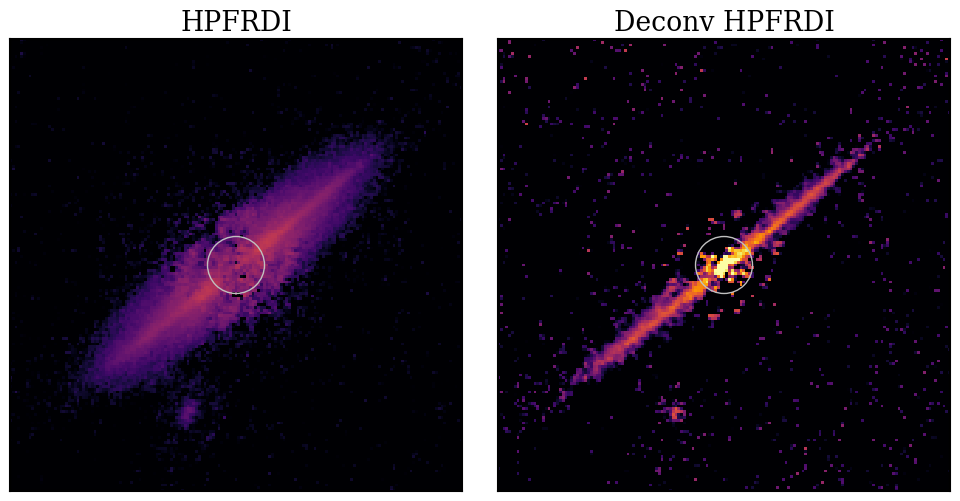

In [37]:
clim = np.array([0.001, 1])*np.nanpercentile(deconv_reduc.im, 99.975)

reducs = [reduc, deconv_reduc]
fig,axes = quick_implot([r.im for r in reducs], extent=reduc.extent, lims=[-5,5], cmap='inferno', clim=clim, norm=mpl.colors.LogNorm,
             interpolation='None', norm_kwargs=dict(clip=True), show=False)

for i,ax in enumerate(axes):
    ax.set_title(reducs[i].reduc_label.replace(' (Winnie)', ''))
    ax.add_patch(mpl.patches.Circle((0,0), radius=0.63, edgecolor='silver', facecolor='None'))

In [38]:
HTML(animate_quick_implot(deconv_iters_comb, extent=reduc.extent, lims=[-5,5], cmap='inferno', clim=clim, norm=mpl.colors.LogNorm,
                          interpolation='None', norm_kwargs=dict(clip=True), titles=return_iters+1).to_jshtml())

Under the hood, deconvolution works to achieve the same goal as forward modeling: it seeks an image that, when convolved with the instrumental response, best matches the data. 

We can treat our deconvolved image just like a raw model image to get a (re-)convolved result to compare with our data.

In [39]:
wdb.set_circumstellar_model(raw_model=np.nan_to_num(deconv_reduc.im), raw_model_center=deconv_reduc.c_star, raw_model_pxscale=deconv_reduc.pxscale)

reconv_reduc = wdb.derotate_and_combine_circumstellar_model()

In [41]:
# Load our MCRDI reduction and the corresponding model so we can compare residuals

mcrdi_reduc = winnie.SpaceReduction(spacerdi=wdb, output_ext='mcrdi_psfsub')
model_reduc = winnie.SpaceReduction(spacerdi=wdb, output_ext='cssmodel')

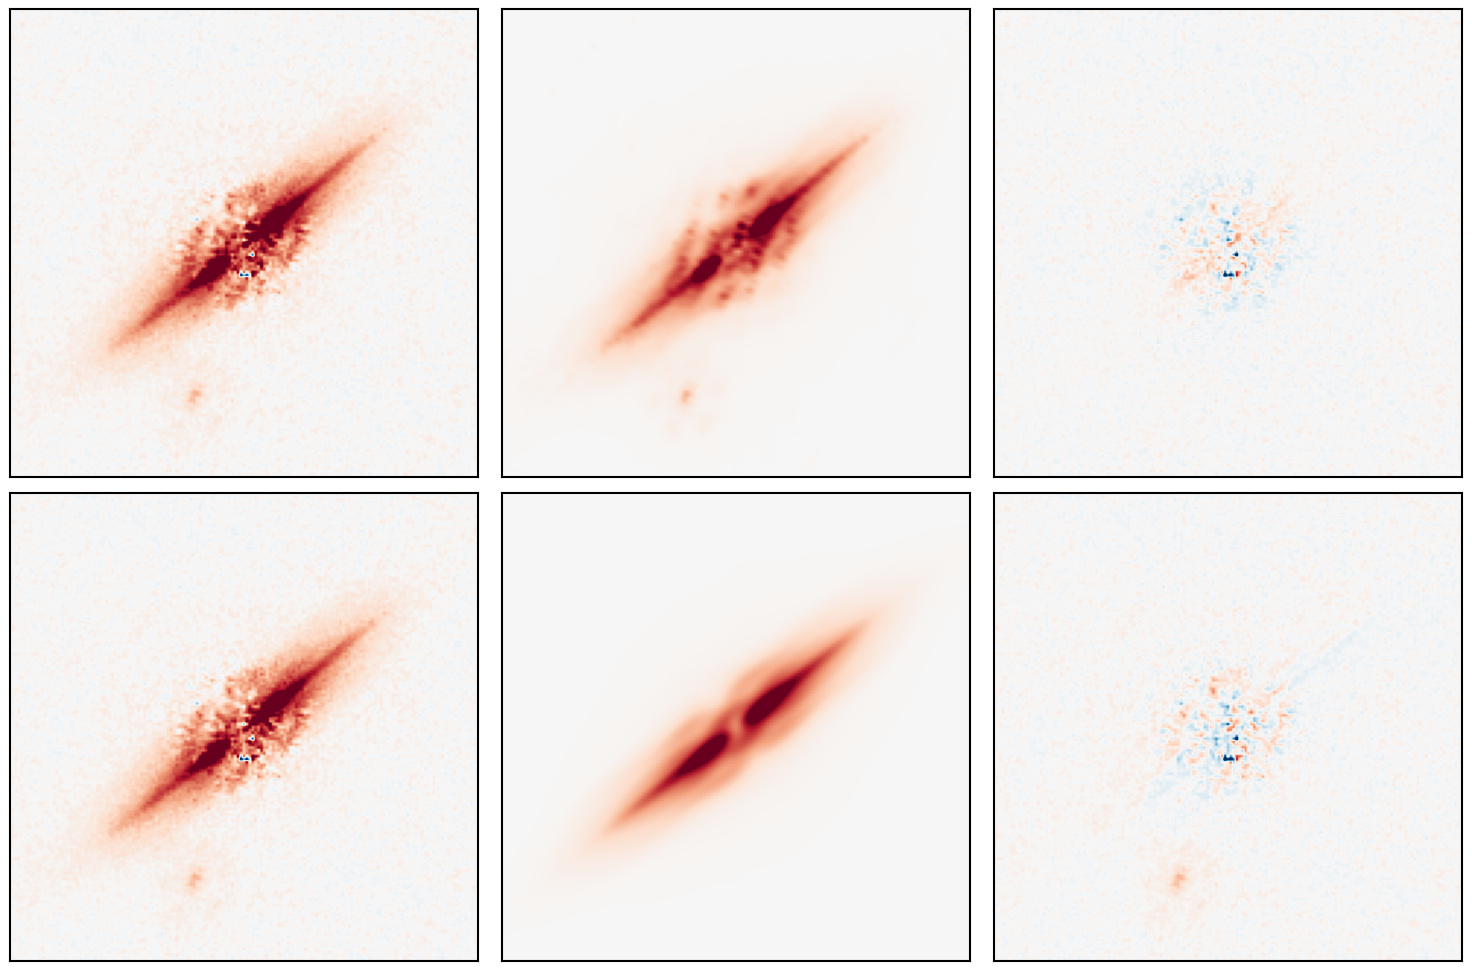

In [42]:
quick_implot([[reduc.im, reconv_reduc.im, reduc.im-reconv_reduc.im],
              [mcrdi_reduc.im, model_reduc.im, mcrdi_reduc.im-model_reduc.im]], 
             extent=reduc.extent, lims=[-5,5], clim_perc=99.9, cmap='RdBu_r')

The deconvolved result does a little worse at small separations and a little better at wide separations. 

(with better radial sampling for the PSF grid, the disadvantage at small seps goes away)

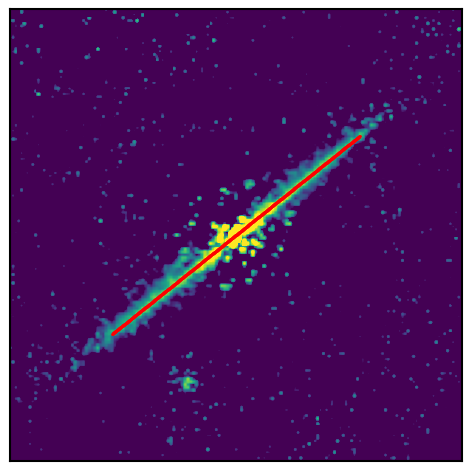

In [52]:
# Now, let's see how similar the disk surface brightness measurements are between the raw model from forward modeling and the deconvolved image
from photutils.aperture import CircularAperture, aperture_photometry

pa = 128.65

x0_spine = np.linspace(-3.5, 3.5, 1000)
y0_spine = np.repeat(0, x0_spine.shape[0])

xy_spine = np.array(winnie.utils.xy_polar_ang_displacement(x0_spine, y0_spine, (pa-90.)))
xy_spine_px = winnie.utils.ang_size_to_px_size(xy_spine, wdb.pxscale).value + reduc.c_star[:, np.newaxis]

model = winnie.SpaceReduction(spacerdi=wdb, concat=0, output_ext='rawmodel')

fig,ax = quick_implot(deconv_reduc.im, extent=reduc.extent, show=False, lims=[-5,5], norm=mpl.colors.LogNorm, norm_kwargs=dict(clip=True), clim='0.01*99.9%, 99.9%')

ax.scatter(*xy_spine, c='red', s=1)

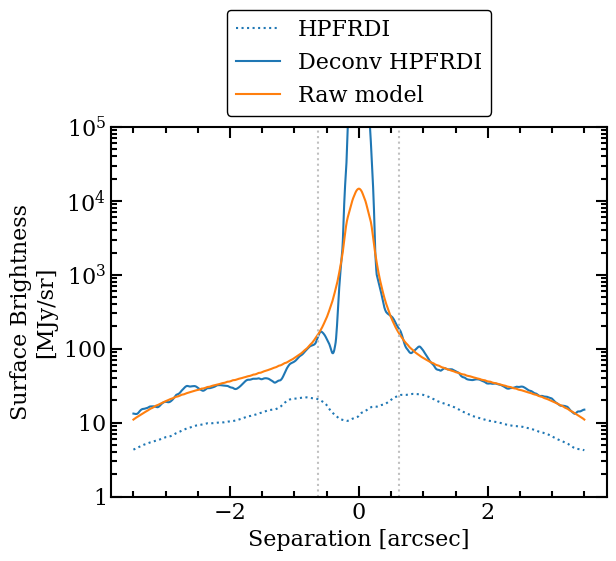

In [54]:
aperrad = 2

apers = CircularAperture(xy_spine_px.T, aperrad)

fig,ax = plt.subplots()

ls = ['dotted', 'solid']
for i,red in enumerate([reduc, deconv_reduc]):
    sbvals = aperture_photometry(red.im, apers)['aperture_sum']/apers.area
    ax.plot(x0_spine, sbvals, c='C0', ls=ls[i], label=red.reduc_label.replace(' (Winnie)', ''))
    
sbvals = aperture_photometry(model.im, apers)['aperture_sum']/apers.area
ax.plot(x0_spine, sbvals, c='C1', ls=ls[i], label='Raw model')
    
ax.set_yscale('log')

ax.set_ylim(1, 100000)

ax.axvline(0.63, c='silver', ls='dotted')
ax.axvline(-0.63, c='silver', ls='dotted')

lgd = ax.legend(framealpha=1, edgecolor='k', fontsize=16, loc='lower center', bbox_to_anchor=[0.5, 1])

ax.set_xlabel('Separation [arcsec]')
ax.set_ylabel('Surface Brightness\n[MJy/sr]')

plt.show()

Besides well within the IWA, we've recovered an answer that's generally consistent with the one from forward modeling. Notably, we've done this using a framework that makes zero assumptions about the underlying disk, and which requires significantly less run time and preparation. 

For disk-focused studies, deconvolution of HPFRDI reductions can provide a very quick path to negligibly biased multi-filter analyses. Moreover, it can provide an option for disks that cannot be feasibly modeled. 

Finally, I'll note that, for the specific case of AU Mic, the departure of the deconvolved brightness from that of the model to the south-east (negative separations above) may well be astrophysical. This is the side of the disk that has shown significant radial structure in prior studies. 

# Jack-knife Resampling

See the docstring for SpaceRDI.jackknife_references for more details/motivation

In [55]:
# Initialize the spaceKLIP database
Database = database.Database(base_dir)
Database.verbose = False
Database.read_jwst_s012_data(datapaths=fitsfiles)

# Create the SpaceRDI object we'll use to carry out RDI
wdb = winnie.SpaceRDI(Database, output_subdir='WinnieRDI', overwrite=True, verbose=True, pad_data='auto')

wdb.load_concat(0)

wdb.hpfrdi_presets()

reduc = wdb.run_rdi()

JWST_NIRCAM_NRCALONG_F356W_MASKRND_MASK335R_SUB320A335R
Science data:   2 exposures of shape (429,430)
Reference data: 6 exposures of shape (429,430)

RDI Settings:
Mode: RDI (Winnie)
Extension for output files: 'rdi_psfsub'
1 optimization zone(s)
1 subtraction zone(s)
JWST_NIRCAM_NRCALONG_F356W_MASKRND_MASK335R_SUB320A335R
Science data:   2 exposures of shape (429,430)
Reference data: 6 exposures of shape (429,430)

RDI Settings:
Mode: HPFRDI (Winnie)
'opt_smoothing_fn': <function high_pass_filter_sequence at 0x1369f1c60>
'opt_smoothing_kwargs': {'filtersize': np.float64(0.969667093183099)}
Extension for output files: 'hpfrdi_psfsub'
1 optimization zone(s)
1 subtraction zone(s)


In [56]:
inds_jk, rescube_jk, errcube_jk = wdb.jackknife_references(derotate=True, exclude_by_visitid=True)

  0%|          | 0/6 [00:00<?, ?it/s]

In [58]:
HTML(animate_quick_implot(np.nanmean(rescube_jk, axis=1), extent=reduc.extent, panelsize=(7,7), cmap='RdBu_r', clim_perc=99.5).to_jshtml())

# Saving/loading a Winnie SpaceRDI object to/from a FITS file

In [17]:
# Initialize the spaceKLIP database
Database = database.Database(base_dir)
Database.verbose = False
Database.read_jwst_s012_data(datapaths=fitsfiles)

# Create the SpaceRDI object
wdb = winnie.SpaceRDI(Database, output_subdir='WinnieRDI', overwrite=True, verbose=True, pad_data='auto', 
                      save_instance=True, efficient_saving=True)

wdb.load_concat(0)

wdb.rdi_presets(output_ext='rdiSaveTest_psfsub')

wdb.r_opt = 1.5*u.arcsec

wdb.update_annular_zones()

reduc = wdb.run_rdi(save_products=True)

# Delete our current SpaceRDI object
del wdb

JWST_NIRCAM_NRCALONG_F356W_MASKRND_MASK335R_SUB320A335R
Science data:   2 exposures of shape (429,430)
Reference data: 6 exposures of shape (429,430)

RDI Settings:
Mode: RDI (Winnie)
Extension for output files: 'rdi_psfsub'
1 optimization zone(s)
1 subtraction zone(s)
JWST_NIRCAM_NRCALONG_F356W_MASKRND_MASK335R_SUB320A335R
Science data:   2 exposures of shape (429,430)
Reference data: 6 exposures of shape (429,430)

RDI Settings:
Mode: RDI (Winnie)
Extension for output files: 'rdiSaveTest_psfsub'
1 optimization zone(s)
1 subtraction zone(s)


[spaceKLIP.database:WARNING]   --> Could not find KL mode in header, assuming default value of 50


JWST_NIRCAM_NRCALONG_F356W_MASKRND_MASK335R_SUB320A335R
Science data:   2 exposures of shape (429,430)
Reference data: 6 exposures of shape (429,430)

RDI Settings:
Mode: RDI (Winnie)
Extension for output files: 'rdiSaveTest_psfsub'
1 optimization zone(s)
1 subtraction zone(s)


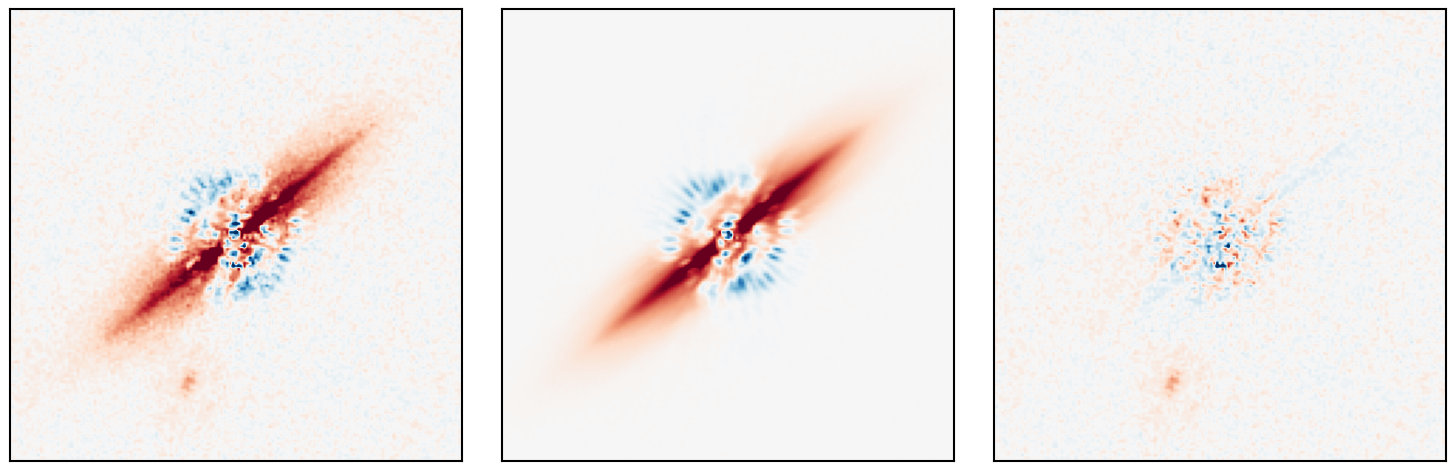

In [18]:
# Load our entire previous SpaceRDI object directly from the reduction FITS file we just created

wdb = winnie.SpaceRDI(from_fits=reduc.filename)

wdb.report_current_config()

# Load the circumstellar model we saved to disk in Tutorial 2

wdb.set_circumstellar_model(model_ext='cssmodel')

# Forward model it using our restored SpaceRDI instance

fm_reduc = wdb.run_rdi(forward_model=True)

del wdb

quick_implot([reduc.im, fm_reduc.im, reduc.im-fm_reduc.im], cmap='RdBu_r', clim_perc=99.9, extent=reduc.extent, lims=[-5,5])

With efficient_saving=True, the image files themselves are not included in the saved instance. Rather, the images are assumed to be stored in the same location as before and are repopulated when the SpaceRDI instance is loaded. This will likely only work on your current machine and may not lead to fully reproducible results (e.g., if you change the referenced files thereafter). If the paths are relative, and if the relative directory structure remains intact, it should be possible to transfer such an instance between users/machines.

With efficient_saving=False, the entire SpaceRDI object is saved. Especially if a PSF grid is currently loaded, this can result in large FITS file sizes (~GBs). However, the benefit is that loading the SpaceRDI instance should be relatively robust and much more transferable. 

save_instance is False by default, and it is not intended to replace good book-keeping. Your best bet will always be to save your Python scripts / Jupyter notebooks, etc, and to ensure that your FITS files are not altered. 

Rather, this option is primarily intended to ease use of other analysis tools. E.g., distributed/parallel disk modeling frameworks where each worker would need a distinct SpaceRDI object that would otherwise need to be recreated in its entirety for each iteration:

In [30]:
def recreate_instance():
    base_dir = './aumic_rdi_example/'
    input_dir = f'{base_dir}coadded/'
    data_ext = 'calints'
    fitsfiles = np.sort(glob.glob(f'{input_dir}*{data_ext}.fits'))

    Database = database.Database(base_dir)
    Database.verbose = False
    Database.read_jwst_s012_data(datapaths=fitsfiles)

    wdb = winnie.SpaceRDI(Database, output_subdir='WinnieRDI',
                          overwrite=True, verbose=False, 
                          pad_data='auto')

    wdb.load_concat(0)
    wdb.rdi_presets()
    wdb.r_opt = 1.5*u.arcsec
    wdb.update_annular_zones()

%timeit recreate_instance()

1.19 s ± 21.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
def load_instance(reducfile):
    wdb = winnie.SpaceRDI(from_fits=reducfile)

%timeit load_instance(reduc.filename)

43.1 ms ± 1.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Loading is a factor of ~30$\times$ faster here.

Additionally, this could be a good option for saving a "final" reduction prior to publication — effectively consolidating the files needed to reproduce a result to a single FITS file.